In [8]:
!pip install kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanishabanik","key":"153b1d85a6438db277942066c58e6f93"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Change the permission
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
!kaggle datasets download -d moltean/fruits


 99% 727M/734M [00:10<00:00, 101MB/s] 
100% 734M/734M [00:10<00:00, 71.5MB/s]


In [12]:
from zipfile import ZipFile
file_name="fruits.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import os
from glob import glob

In [14]:
train_files = glob('../content/fruits-360_dataset/fruits-360/Training/*/*.jpg')
#test_files = glob('/content/seg_test/seg_test/*/*.jpg')
print(len(train_files))

60498


In [15]:
train_files[0]

'../content/fruits-360_dataset/fruits-360/Training/Mulberry/r_269_100.jpg'

In [0]:
test_files = glob('../content/fruits-360_dataset/fruits-360/Test/*/*.jpg')

In [0]:
classes = os.listdir('/content/fruits-360_dataset/fruits-360/Training/')
encoder = {}
decoder = {}
for idx,cl in enumerate(classes):
  encoder[cl] = idx
  decoder[idx] = cl

In [0]:
from PIL import Image

In [19]:
type(train_files[0])

str

In [0]:
pic=Image.open(train_files[30])

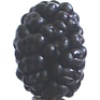

In [21]:
pic

In [0]:
import numpy as np

In [23]:
pic_arr = np.asarray(pic)
pic_arr.shape[1]

100

In [0]:
rows=[]
col=[]
for image in train_files:
  pic1=Image.open(image)
  pic1_arr = np.asarray(pic)
  rows.append(pic1_arr.shape[0])
  col.append(pic1_arr.shape[1])
average_rows=round((sum(rows)/60498),2)
average_col=round((sum(col)/60498),2)

In [25]:
average_rows

100.0

In [26]:
average_col

100.0

In [0]:
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import cv2

In [0]:
#lb=[]
class fruit_360_dataset(Dataset):
    def __init__(self,files,encoder,transform):
      self.files = files
      self.encoder = encoder
      self.transform = transform
    def __len__(self):
      return len(self.files)
    def __getitem__(self,idx):
      image_path = self.files[idx]
      image = cv2.imread(image_path)
      if(self.transform):
        image = self.transform(image)
      label = image_path.split('/')[-2]
      #lb.append(label)
      return image,self.encoder[label]
im_size = 100
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

In [0]:
lb=[]
for l in train_files:
  lb.append(l.split('/')[-2])

In [30]:
print(len(set(lb)))

120


In [0]:
train_dataset = fruit_360_dataset(train_files,encoder,train_transforms)
test_dataset = fruit_360_dataset(test_files,encoder,train_transforms)
train_loader = DataLoader(train_dataset,shuffle = True,batch_size = 64)
test_loader = DataLoader(test_dataset,batch_size = 64)

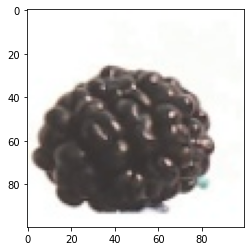

In [66]:
image,label = train_dataset[0]
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image
import matplotlib.pyplot as plt
plt.imshow(im_convert(image))

In [0]:
from torch import nn
from torchvision import models
class classifie(nn.Module):
    def __init__(self,n_classes,pretrained = True ):
        super(classifie, self).__init__()
        self.cnn_arch = models.resnet18(pretrained = pretrained)
        self.linear1 = nn.Linear(1000,n_classes)
        self.relu = nn.LeakyReLU()
        #self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.7)
    def forward(self, input):
        am = self.cnn_arch(input)
        x = self.dropout(self.relu(am))
        x = self.linear1(x)
        return x

In [0]:
model = classifie(120).cuda()

In [0]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [74]:
epochs=10
visualize = 1000
for epoch in range(epochs):
  acc_epoch = 0
  loss_epoch = 0
  for idx,(image,labels) in enumerate(train_loader):
    image = image.cuda()
    labels = labels.cuda()
    output = model(image)
    loss = criterion(output,labels)
    acc = 100 * (output.detach().argmax(1) == labels).cpu().numpy().mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc_epoch += acc
    loss_epoch += loss.item()
    if(idx%visualize == 0):
      print('batch loss {}, accuracy {}'.format(loss_epoch/(idx+1),acc_epoch/(idx+1)))
  print('epoch loss {}, accuracy {}'.format(loss_epoch/len(train_loader),acc_epoch/len(train_loader)))

batch loss 0.002986907958984375, accuracy 100.0
epoch loss 0.0039391967347410465, accuracy 99.9025502114165
batch loss 1.1913478374481201e-05, accuracy 100.0
epoch loss 0.0007392050136997114, accuracy 99.97852801268499
batch loss 8.981674909591675e-05, accuracy 100.0
epoch loss 0.0008819816164905821, accuracy 99.98017970401692
batch loss 0.00010624527931213379, accuracy 100.0
epoch loss 0.0011745260406871767, accuracy 99.98017970401692
batch loss 5.796551704406738e-06, accuracy 100.0
epoch loss 0.0020217944085981943, accuracy 99.95779011040638
batch loss 6.625056266784668e-05, accuracy 100.0
epoch loss 0.001679387810581464, accuracy 99.96035940803382
batch loss 4.567205905914307e-06, accuracy 100.0
epoch loss 0.0005662283278316511, accuracy 99.98678646934461
batch loss 2.0563602447509766e-06, accuracy 100.0
epoch loss 0.0015975542762267539, accuracy 99.96861786469344
batch loss 0.0002192482352256775, accuracy 100.0
epoch loss 0.0013155710330158157, accuracy 99.98843816067654
batch loss

In [75]:
for epoch in range(epochs):
  acc_epoch = 0
  loss_epoch = 0
  for idx,(image,labels) in enumerate(test_loader):
    image = image.cuda()
    labels = labels.cuda()
    output = model(image)
    loss = criterion(output,labels)
    acc = 100 * (output.detach().argmax(1) == labels).cpu().numpy().mean()
    acc_epoch += acc
    loss_epoch += loss.item()
    if(idx%visualize == 0):
      print('batch loss {}, accuracy {}'.format(loss_epoch/(idx+1),acc_epoch/(idx+1)))
  print('epoch loss {}, accuracy {}'.format(loss_epoch/len(test_loader),acc_epoch/len(test_loader)))

batch loss 14.775952339172363, accuracy 0.0
epoch loss 13.971455674422415, accuracy 5.558243034055727
batch loss 15.250509262084961, accuracy 3.125
epoch loss 13.94954097529314, accuracy 5.764180672268908
batch loss 14.929697036743164, accuracy 1.5625
epoch loss 13.921930856379932, accuracy 5.838815789473684
batch loss 15.184918403625488, accuracy 1.5625
epoch loss 13.969324671447092, accuracy 5.925890092879257
batch loss 15.149896621704102, accuracy 1.5625
epoch loss 13.957048717298006, accuracy 5.703366873065016
batch loss 14.936211585998535, accuracy 0.0
epoch loss 13.968365964505695, accuracy 5.928654356479433
batch loss 14.557761192321777, accuracy 0.0
epoch loss 13.973750362455291, accuracy 5.889954666076957
batch loss 15.114906311035156, accuracy 1.5625
epoch loss 13.97878440762452, accuracy 5.783530517470146
batch loss 15.218501091003418, accuracy 0.0
epoch loss 13.94996849597423, accuracy 5.940402476780186
batch loss 15.212883949279785, accuracy 1.5625
epoch loss 13.9349439963